modern_education_share: Share of state (municipal) educational organizations, corresponding to modern requirements of education in the total number of high schools;
old_education_build_share: The share of state (municipal) educational organizations, buildings are in disrepair and in need of major repairs of the total number.
    child_on_acc_pre_school: Number of children waiting for the determination to pre-school educational institutions, for capacity of 100

In [3]:
from sklearn import model_selection, preprocessing
import xgboost as xgb

train_df = pd.read_csv('dss-regression-datasets/project-sberbank-housing-market-data/macro.csv')
price_time = pd.read_csv('dss-regression-datasets/project-sberbank-housing-market-data/train.csv')
price_time_df = price_time[['price_doc', 'timestamp']]

In [4]:
color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [9]:
train_df.isnull().sum()

timestamp                                        0
oil_urals                                        0
gdp_quart                                       90
gdp_quart_growth                                90
cpi                                             31
ppi                                             31
gdp_deflator                                   365
balance_trade                                   31
balance_trade_growth                            90
usdrub                                           3
eurrub                                           3
brent                                            3
net_capital_export                             396
gdp_annual                                       0
gdp_annual_growth                                0
average_provision_of_build_contract              0
average_provision_of_build_contract_moscow     365
rts                                             10
micex                                           10
micex_rgbi_tr                  

In [9]:
train_df.shape

(2484, 100)

## Oils price Check

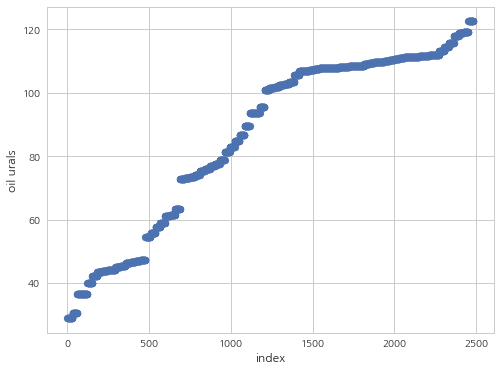

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.oil_urals.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('oil urals', fontsize=12)
plt.show()

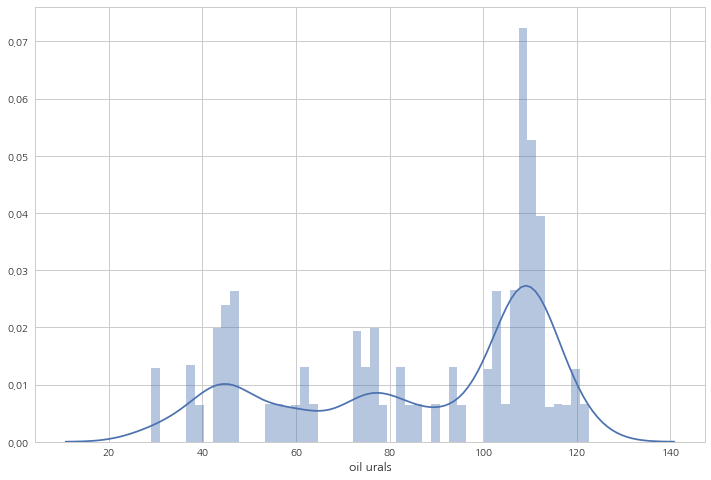

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.oil_urals.values, bins=50, kde=True)
plt.xlabel('oil urals', fontsize=12)
plt.show()

In [25]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x : x[:4] + x[5:7])
grouped_df = train_df.groupby('yearmonth')['oil_urals'].aggregate(np.median).reset_index()

## Timeseries Oils price with median

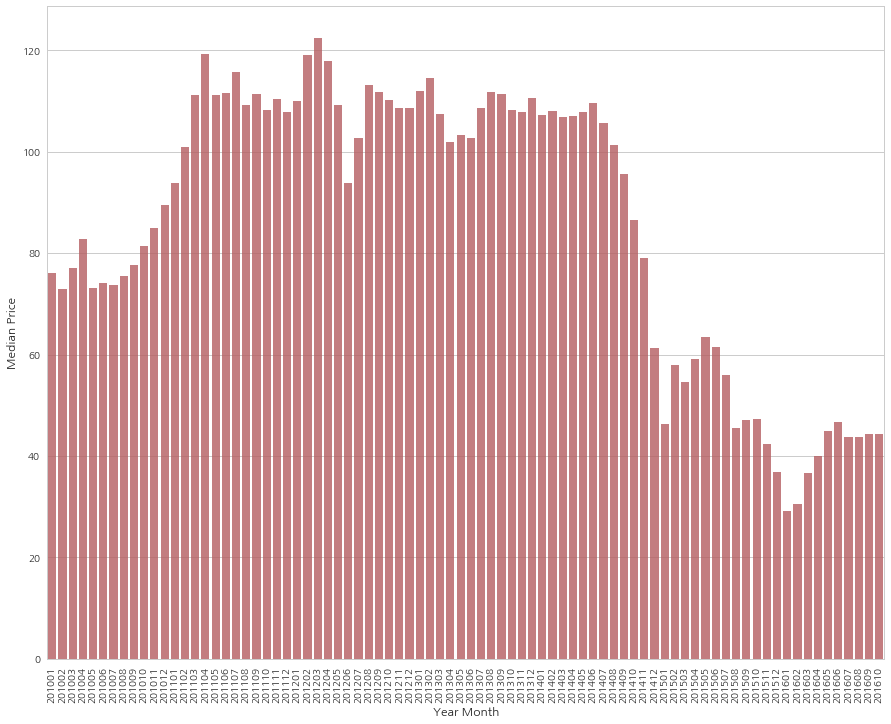

In [20]:
plt.figure(figsize=(15,12))
sns.barplot(grouped_df.yearmonth.values, grouped_df.oil_urals.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Column Type & Count

In [63]:
train_df = pd.read_csv('dss-regression-datasets/project-sberbank-housing-market-data/macro.csv', parse_dates=['timestamp'])
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,datetime64[ns],1
1,int64,2
2,float64,94
3,object,3


In [23]:
train_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,175.15,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,178.66,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,43.4054,80.12,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,183.44,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.

In [27]:
train_df.shape

(2484, 101)

In [33]:
dtype_df

,Count,Column Type
0,timestamp,datetime64[ns]
1,oil_urals,float64
2,gdp_quart,float64
3,gdp_quart_growth,float64
4,cpi,float64
5,ppi,float64
6,gdp_deflator,float64
7,balance_trade,float64
8,balance_trade_growth,float64
9,usdrub,float64


## Missing Values Check

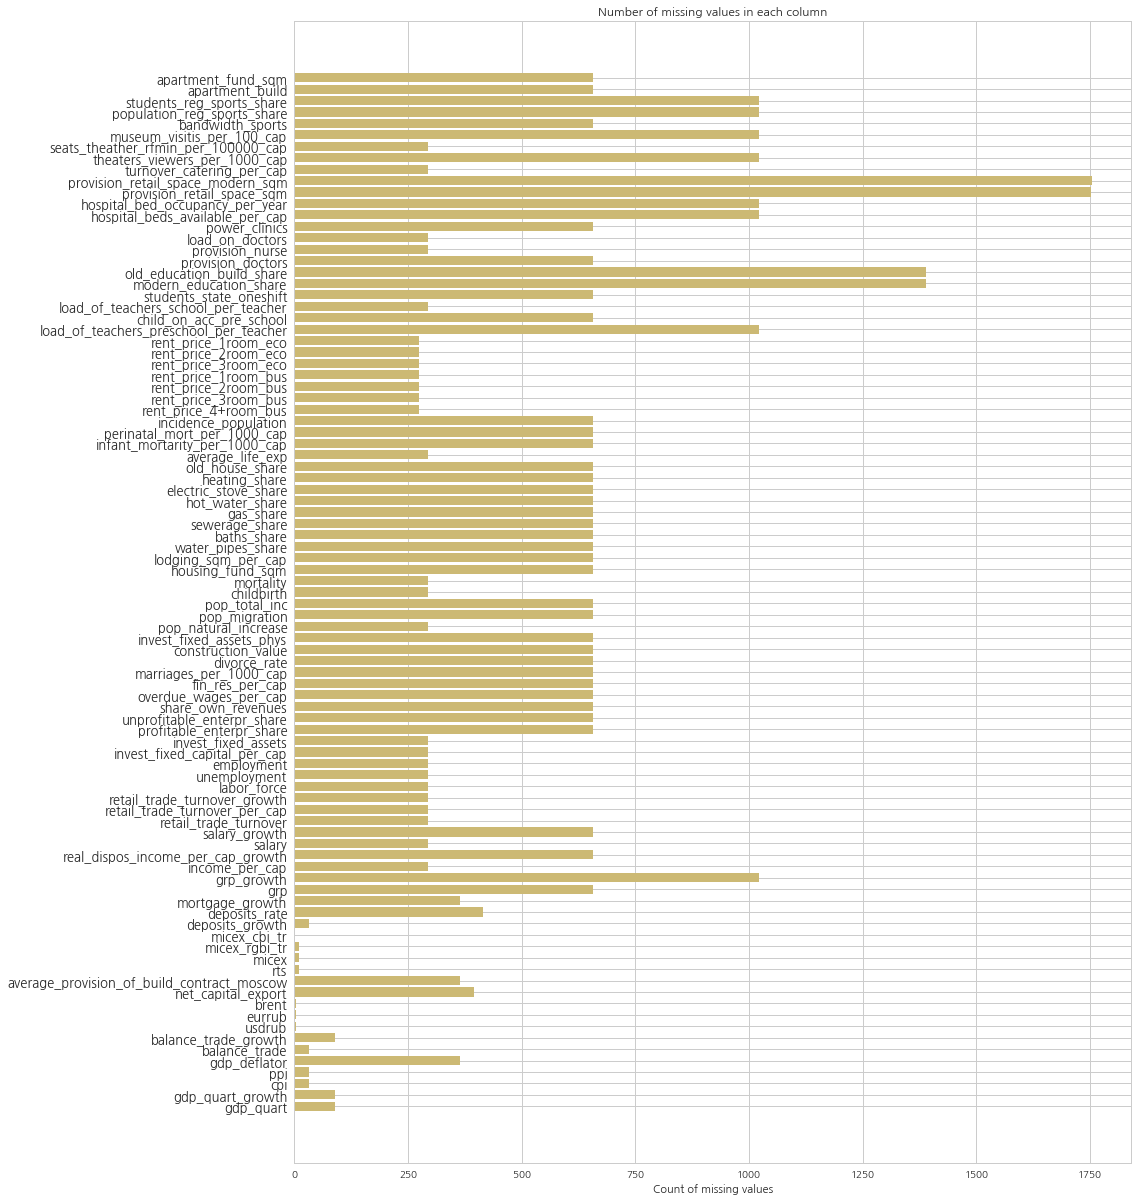

In [44]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(15,21))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal', fontsize=13)
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

## XGB Boost (Encoding)

In [154]:
train_df_xgb = train_df
for f in train_df_xgb.columns:
    if train_df_xgb[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df_xgb[f].values))
        train_df_xgb[f] = lbl.transform(list(train_df_xgb[f].values))
        print(f)

train_df_xgb[['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']]


,child_on_acc_pre_school,modern_education_share,old_education_build_share
0,3,3,3
1,3,3,3
2,3,3,3
3,3,3,3
4,3,3,3
5,3,3,3
6,3,3,3
7,3,3,3
8,3,3,3
9,3,3,3


In [64]:
# train_df_object = train_df.select_dtypes(include=['object']).copy()
train_df_object.head(n=100)

,child_on_acc_pre_school,modern_education_share,old_education_build_share
0,"45,713",NaN,NaN
1,"45,713",NaN,NaN
2,"45,713",NaN,NaN
3,"45,713",NaN,NaN
4,"45,713",NaN,NaN
5,"45,713",NaN,NaN
6,"45,713",NaN,NaN
7,"45,713",NaN,NaN
8,"45,713",NaN,NaN
9,"45,713",NaN,NaN


# Merge train_df with house price grouped by yearmonth (others are meaned)

In [156]:
train_df_xgb['timestamp'] = train_df['timestamp']
price_time_df['yearmonth'] = price_time_df['timestamp'].apply(lambda x:x[:4] + x[5:7])
train_df_xgb['yearmonth'] = train_df_xgb['timestamp'].apply(lambda x:x[:4] + x[5:7])
price_time_df_grouped = price_time_df.groupby('yearmonth').aggregate(np.mean).reset_index()
train_df_xgb_grouped = train_df_xgb.groupby('yearmonth').aggregate(np.mean).reset_index()

In [90]:
train_df_xgb_merge = pd.merge(train_df_xgb_grouped, price_time_df_grouped, how='inner', on='yearmonth')

## Feature Importance

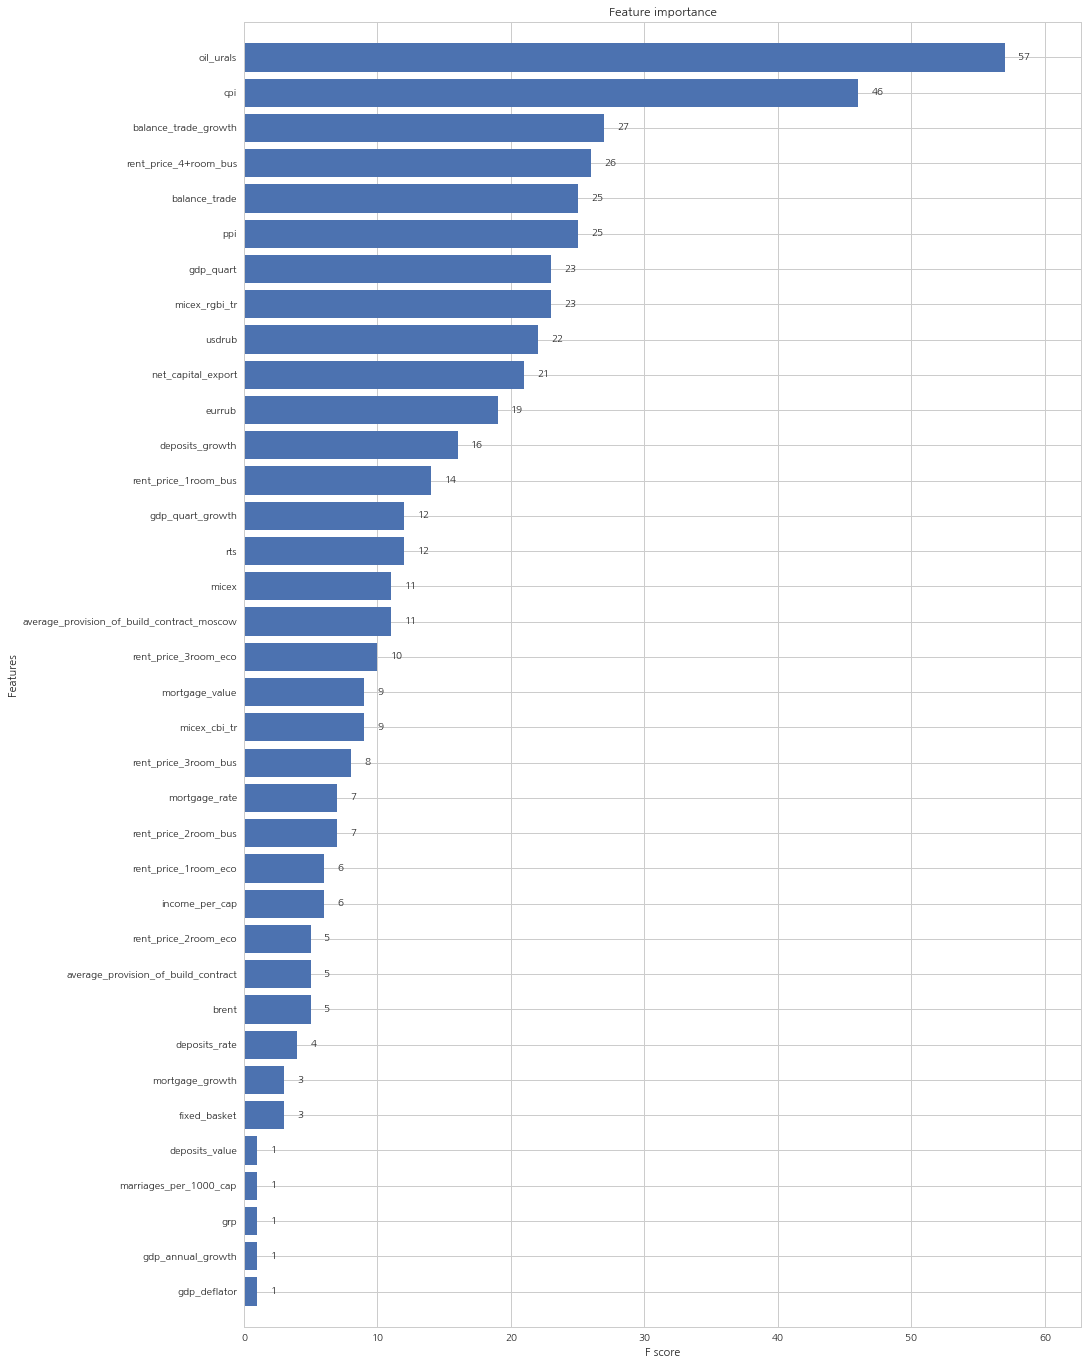

In [138]:
train_y = train_df_xgb_merge.price_doc
train_X = train_df_xgb_merge.drop(['yearmonth', 'price_doc'], axis=1)

xgb_params = {
    'eta' : 0.05,
    'max_depth' : 8,
    'subsample' : 0.7,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'silent' : 1
}

dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)


fig, ax = plt.subplots(figsize=(15,24))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

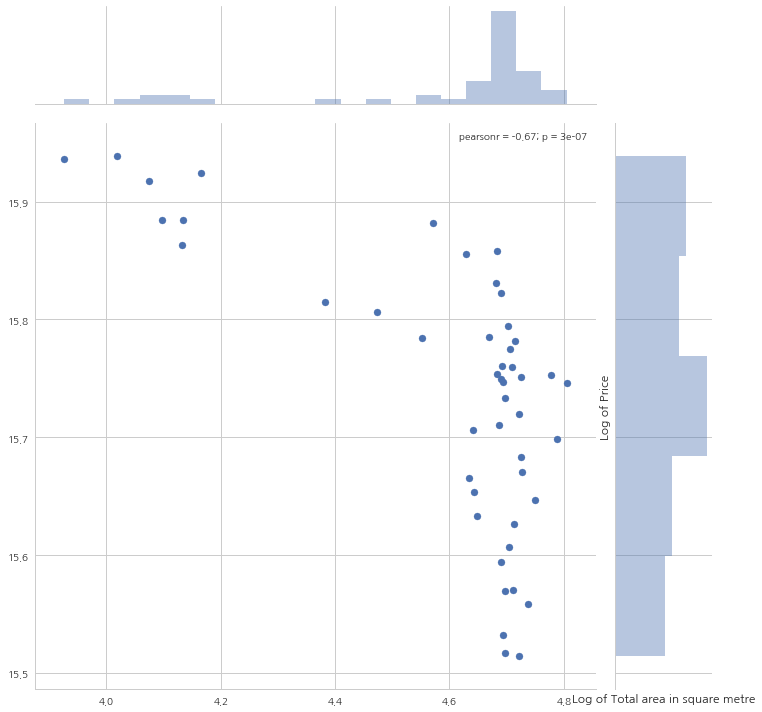

In [141]:
ulimit = np.percentile(train_df_xgb_merge.price_doc.values, 99.5)
llimit = np.percentile(train_df_xgb_merge.price_doc.values, 0.5)
train_df_xgb_merge['price_doc'][train_df_xgb_merge['price_doc']>ulimit] = ulimit
train_df_xgb_merge['price_doc'][train_df_xgb_merge['price_doc']<llimit] = llimit

col = "oil_urals"
ulimit = np.percentile(train_df_xgb_merge[col].values, 99.5)
llimit = np.percentile(train_df_xgb_merge[col].values, 0.5)
train_df_xgb_merge[col][train_df_xgb_merge[col]>ulimit] = ulimit
train_df_xgb_merge[col][train_df_xgb_merge[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df_xgb_merge.oil_urals.values), y=np.log1p(train_df_xgb_merge.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()


# Merge train_df with house price by timestamp (ungrouped)

In [157]:
train_df_ungrouped_xgb = pd.merge(train_df_xgb, price_time_df, how='inner', on='timestamp')

In [159]:
train_df_ungrouped_xgb.columns

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       ...
       'seats_theather_rfmin_per_100000_cap', 'museum_visitis_per_100_cap',
       'bandwidth_sports', 'population_reg_sports_share',
       'students_reg_sports_share', 'apartment_build', 'apartment_fund_sqm',
       'yearmonth_x', 'price_doc', 'yearmonth_y'],
      dtype='object', length=103)

In [162]:
train_df_ungrouped_xgb

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,yearmonth_x,price_doc,yearmonth_y
0,2011-08-23,109.3100,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.9525,41.7537,109.31,0.301811,46308.5,0.045037,5.76,6.74,1578.91,1444.11,131.45,204.92,10618898,0.009740,4.10,323275,1.051914,11.84,9948.7728,0.187791,42688.6,-0.005,44898.7,0.168917,12838.36,3322.0470,286.952000,106.6,6643.626000,0.014000,0.708000,73976.19863,856.424079,0.708,0.292,0.891478,53636.0,226.214157,8.5,3.8,549075.8,106.6,1.10,5.1,6.2,10.80,9.70,218.0,18.772066,99.9,99.8,99.5,43.9,95.7,55.3,99.9,0.3,75.79,6.2,5.53,715.1,136.11,77.93,62.89,47.85,41.80,36.77,29.07,793.319561,0,1391.710938,89.0495,3,3,65.9,99.6,8180.755454,375.8,846.0,302.0,741.0,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,201108,6000000,201108
1,2011-09-01,111.2900,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,28.9655,41.4014,114.29,0.599709,46308.5,0.045037,5.76,6.74,1703.86,1551.58,131.45,205.42,10720911,0.009607,4.00,386388,1.049543,11.92,9948.7728,0.187791,40311.3,-0.005,44898.7,0.168917,12856.97,3322.0470,286.952000,106.6,6643.626000,0.014000,0.708000,73976.19863,856.424079,0.708,0.292,0.891478,53636.0,226.214157,8.5,3.8,549075.8,106.6,1.10,5.1,6.2,10.80,9.70,218.0,18.772066,99.9,99.8,99.5,43.9,95.7,55.3,99.9,0.3,75.79,6.2,5.53,715.1,155.22,94.02,66.28,51.15,44.25,37.73,30.63,793.319561,0,1391.710938,89.0495,3,3,65.9,99.6,8180.755454,375.8,846.0,302.0,741.0,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,201109,13100000,201109
2,2011-09-05,111.2900,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,29.4625,41.5902,110.08,0.599709,46308.5,0.045037,5.76,6.74,1617.01,1492.83,131.19,198.24,10920215,0.018590,4.00,386388,1.049543,11.92,9948.7728,0.187791,40311.3,-0.005,44898.7,0.168917,12856.97,3322.0470,286.952000,106.6,6643.626000,0.014000,0.708000,73976.19863,856.424079,0.708,0.292,0.891478,53636.0,226.214157,8.5,3.8,549075.8,106.6,1.10,5.1,6.2,10.80,9.70,218.0,18.772066,99.9,99.8,99.5,43.9,95.7,55.3,99.9,0.3,75.79,6.2,5.53,715.1,155.22,94.02,66.28,51.15,44.25,37.73,30.63,793.319561,0,1391.710938,89.0495,3,3,65.9,99.6,8180.755454,375.8,846.0,302.0,741.0,271

## Feature Importance ungrouped

- usdrub: Ruble/USD exchange rate
- eurrub: Ruble/EUR exchange rate 
- brent: London Brent  ($/bbl)
- micex: MICEX index / return
- micex_cbi_tr: MICEX Index corporate bonds (MICEX CBI TR) / yield
- rts: Index RTS / return
- micex_rgbi_tr: MICEX index for government bonds (MICEX RGBI TR) / yield
- oil_urals: Crude Oil Urals ($/bbl)

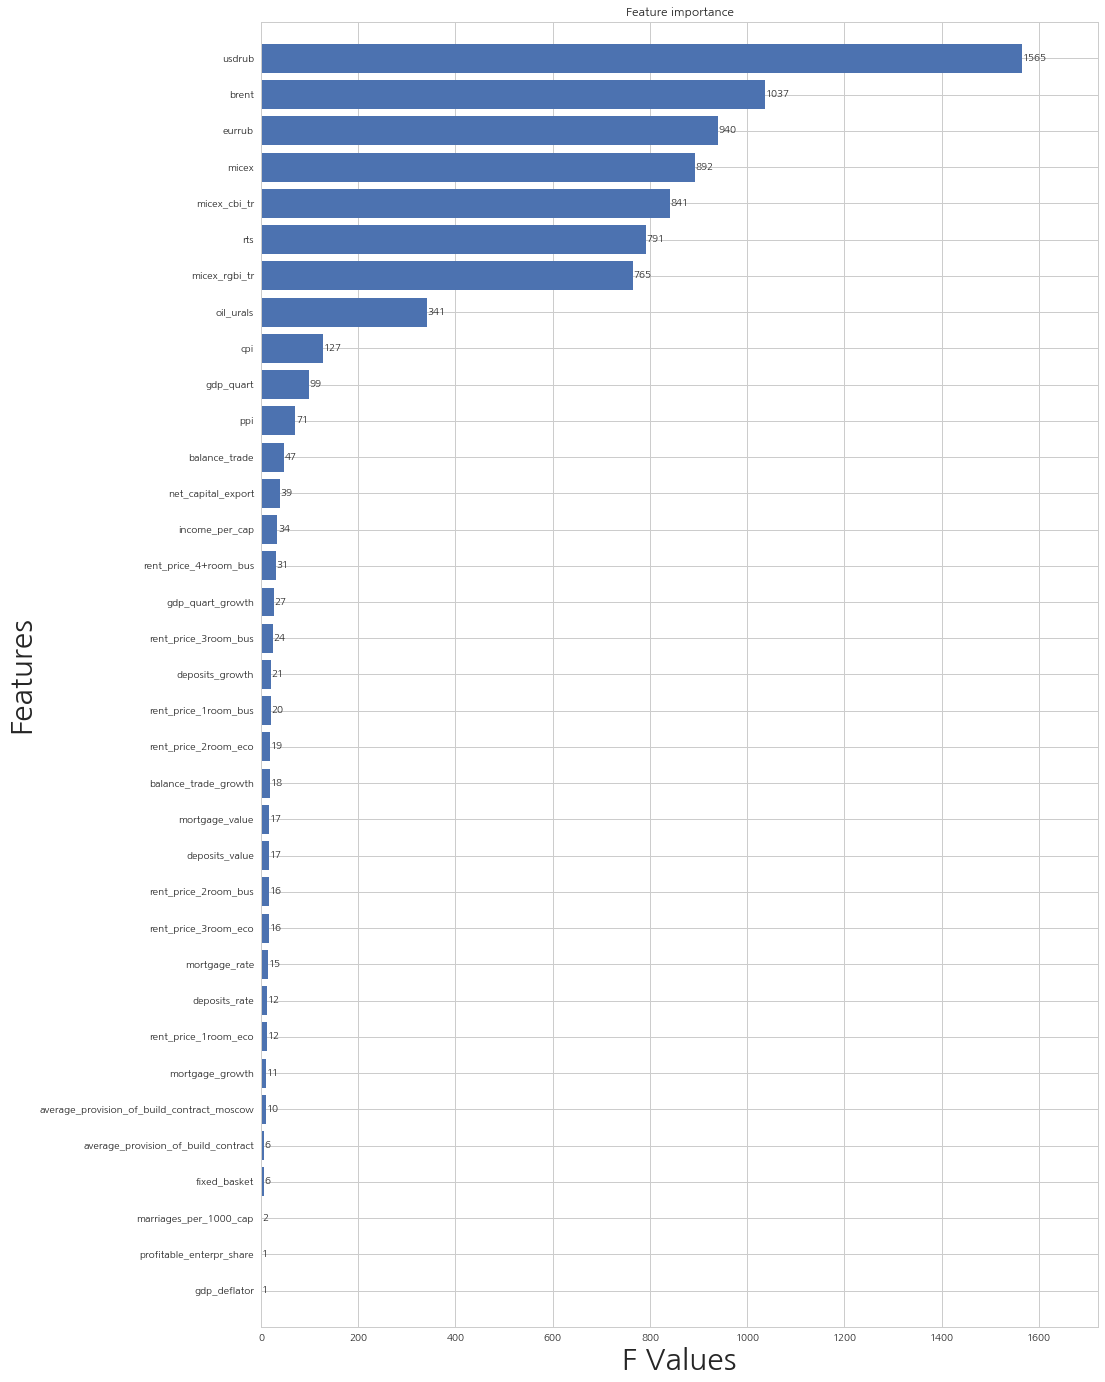

In [174]:
train_y_un = train_df_ungrouped_xgb.price_doc
train_X_un = train_df_ungrouped_xgb.drop(['timestamp', 'price_doc', 'yearmonth_x','yearmonth_y'], axis=1)

xgb_params = {
    'eta' : 0.05,
    'max_depth' : 8,
    'subsample' : 0.7,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'silent' : 1
}

dtrain = xgb.DMatrix(train_X_un, train_y_un, feature_names=train_X_un.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)


fig, ax = plt.subplots(figsize=(15,24))
xgb.plot_importance(model, height=0.8, ax=ax)
ax.set_xlabel('F Values', fontsize=30)
ax.set_ylabel('Features', fontsize=30)
plt.show()

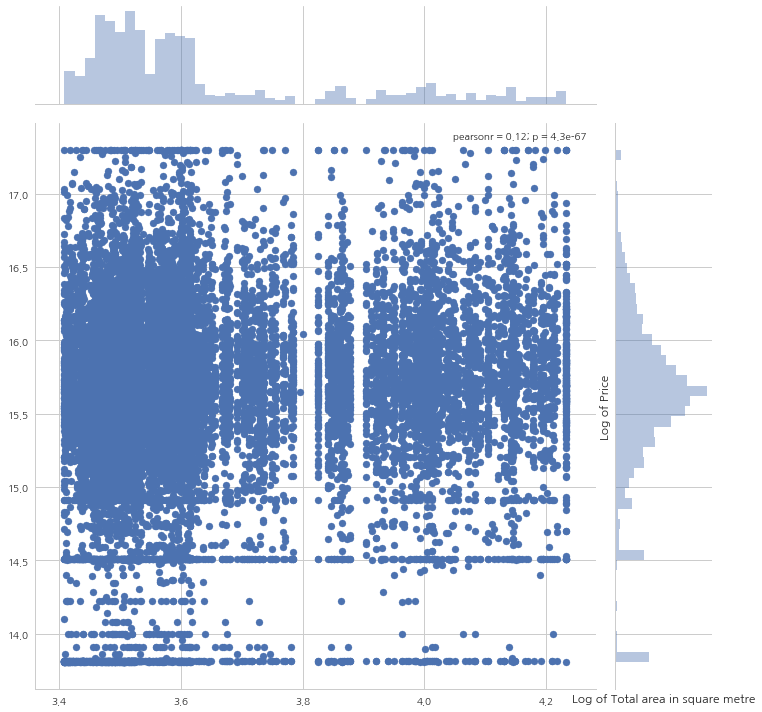

In [165]:
ulimit = np.percentile(train_df_ungrouped_xgb.price_doc.values, 99.5)
llimit = np.percentile(train_df_ungrouped_xgb.price_doc.values, 0.5)
train_df_ungrouped_xgb['price_doc'][train_df_ungrouped_xgb['price_doc']>ulimit] = ulimit
train_df_ungrouped_xgb['price_doc'][train_df_ungrouped_xgb['price_doc']<llimit] = llimit

col = "usdrub"
ulimit = np.percentile(train_df_ungrouped_xgb[col].values, 99.5)
llimit = np.percentile(train_df_ungrouped_xgb[col].values, 0.5)
train_df_ungrouped_xgb[col][train_df_ungrouped_xgb[col]>ulimit] = ulimit
train_df_ungrouped_xgb[col][train_df_ungrouped_xgb[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df_ungrouped_xgb.usdrub.values), y=np.log1p(train_df_ungrouped_xgb.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

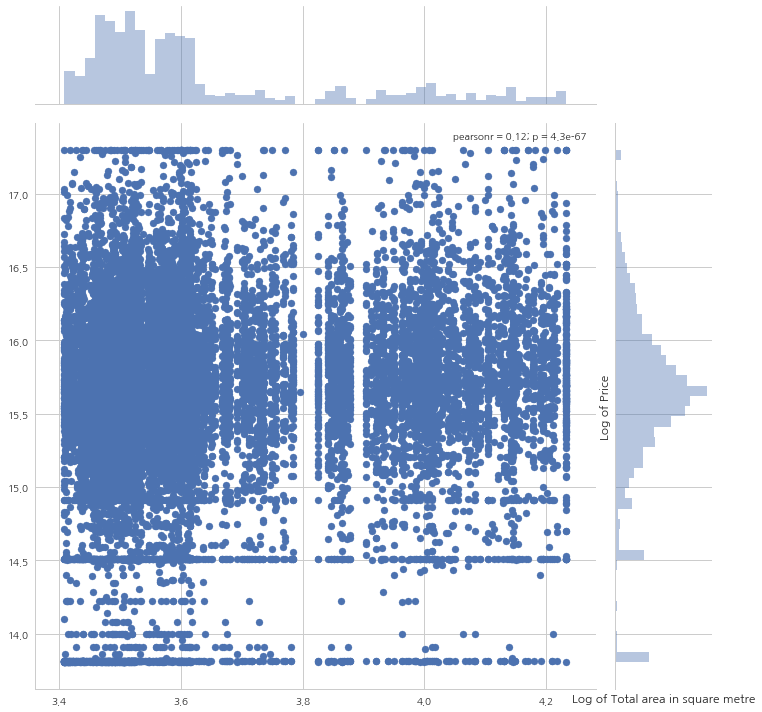

In [166]:
ulimit = np.percentile(train_df_ungrouped_xgb.price_doc.values, 99.5)
llimit = np.percentile(train_df_ungrouped_xgb.price_doc.values, 0.5)
train_df_ungrouped_xgb['price_doc'][train_df_ungrouped_xgb['price_doc']>ulimit] = ulimit
train_df_ungrouped_xgb['price_doc'][train_df_ungrouped_xgb['price_doc']<llimit] = llimit

col = "eurrub"
ulimit = np.percentile(train_df_ungrouped_xgb[col].values, 99.5)
llimit = np.percentile(train_df_ungrouped_xgb[col].values, 0.5)
train_df_ungrouped_xgb[col][train_df_ungrouped_xgb[col]>ulimit] = ulimit
train_df_ungrouped_xgb[col][train_df_ungrouped_xgb[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df_ungrouped_xgb.usdrub.values), y=np.log1p(train_df_ungrouped_xgb.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()